In [1]:
import os
import cv2
import neurokit2 as nk
import numpy as np
import dlib
import matplotlib.pyplot as plt

In [2]:
root = './UBFC_DATASET/DATASET_1/'

dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

dir_name = dirs[4]
vid_folder = os.path.join(root, dir_name)

gt_filename = os.path.join(vid_folder, 'gtdump.xmp')
if os.path.isfile(gt_filename):
    gt_data = np.genfromtxt(gt_filename, delimiter=',')
    gt_time = gt_data[:, 0] / 1000
    gt_hr = gt_data[:, 1]
    gt_trace = gt_data[:, 3]
else:
    gt_filename = os.path.join(vid_folder, 'ground_truth.txt')
    if os.path.isfile(gt_filename):
        gt_data = np.genfromtxt(gt_filename, delimiter=' ')
        gt_trace = gt_data[:, 0]
        gt_hr = gt_data[:, 1]
        gt_time = gt_data[:, 2]

gt_trace = (gt_trace - np.mean(gt_trace)) / np.std(gt_trace)

In [3]:
print("dir_name:", dir_name)
print("vid_folder:", vid_folder)
print("gt_trace shape:", gt_trace.shape)
print("gt_hr shape:", gt_hr.shape)
print("gt_time shape:", gt_time.shape)

dir_name: 6-gt
vid_folder: ./UBFC_DATASET/DATASET_1/6-gt
gt_trace shape: (5192,)
gt_hr shape: (5192,)
gt_time shape: (5192,)


In [4]:
import dlib
import cv2
vid_path = os.path.join(vid_folder, 'vid.avi')
vidObj = cv2.VideoCapture(vid_path)
face_list = []

fps = vidObj.get(cv2.CAP_PROP_FPS)
first_frame = True
tracker = dlib.correlation_tracker()

# Load the face detector and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_81_face_landmarks.dat")

left_cheek_signal = []
right_cheek_signal = []
forehead_signal = []
chin_signal = []

# Function to extract facial landmarks
def extract_facial_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    landmarks = []
    for face in faces:
        shape = predictor(gray, face)
        for i in range(81):
            x = shape.part(i).x
            y = shape.part(i).y
            landmarks.append((x, y))
    return landmarks

def calculate_mean_pixel_values(frame, points):
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)
    masked_frame = cv2.bitwise_and(frame, frame, mask=mask)
    mean_values = np.sum(masked_frame, axis=(0, 1)) / np.count_nonzero(mask)
    return mean_values

# Open the video file
vidObj = cv2.VideoCapture(vid_path)

# Process each frame of the video
while True:
    ret, frame = vidObj.read()
    if not ret:
        break
    
    # Extract facial landmarks
    landmarks = extract_facial_landmarks(frame)

    # Extract signals from corresponding face patches
    left_cheek_signal.append(calculate_mean_pixel_values(frame, np.array(landmarks)[[4, 29, 1]]))
    right_cheek_signal.append(calculate_mean_pixel_values(frame, np.array(landmarks)[[29, 12, 15]]))
    forehead_signal.append(calculate_mean_pixel_values(frame, np.array(landmarks)[[19, 24, 72, 69]]))
    chin_signal.append(calculate_mean_pixel_values(frame, np.array(landmarks)[[8, 12, 57, 4]]))
    

left_cheek_signal    = np.array(left_cheek_signal)
right_cheek_signal   = np.array(right_cheek_signal)
forehead_signal      = np.array(forehead_signal)
chin_signal          = np.array(chin_signal)

In [5]:
left_cheek_signal.shape

(2383, 3)

In [6]:
landmarks[0]

(306, 200)

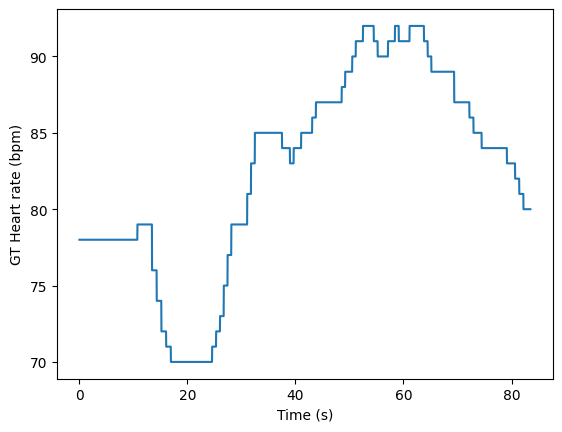

In [7]:
import matplotlib.pyplot as plt
plt.plot(gt_time, gt_hr)
plt.xlabel('Time (s)')
plt.ylabel('GT Heart rate (bpm)')
plt.show()

In [8]:
means = np.array([left_cheek_signal, right_cheek_signal, forehead_signal, chin_signal])
for i in range(means.shape[0]):
    means[i, :,0] = (means[i, :,0] - np.average(means[i, :,0]))/np.std(means[i, :,0])
    means[i, :,1] = (means[i, :,1] - np.average(means[i, :,1]))/np.std(means[i, :,1])
    means[i, :,2] = (means[i, :,2] - np.average(means[i, :,2]))/np.std(means[i, :,2])

In [9]:
# Detrending means

detrended_means = means
for i in range(means.shape[0]):
    detrended_means[i, :,0] = nk.signal_detrend(means[i, :,0], method="tarvainen2002", regularization=120)
    detrended_means[i, :,1] = nk.signal_detrend(means[i, :,1], method="tarvainen2002", regularization=120)
    detrended_means[i, :,2] = nk.signal_detrend(means[i, :,2], method="tarvainen2002", regularization=120)

In [10]:
# Moving average filter

window_size = int(fps*0.18)
kernel = np.ones(window_size) / window_size
filtered_means = detrended_means

for i in range(means.shape[0]):
    filtered_means[i, :,0] = np.convolve(filtered_means[i, :,0],kernel,'same')
    filtered_means[i, :,1] = np.convolve(filtered_means[i, :,1],kernel,'same')
    filtered_means[i, :,2] = np.convolve(filtered_means[i, :,2],kernel,'same')

In [11]:
# PCA decomposition

from sklearn.decomposition import FastICA

transformer = FastICA(n_components = 3)

independent_signals = np.zeros((means.shape))
for i in range(means.shape[0]):
    independent_signals[i] = transformer.fit_transform(filtered_means[i])

In [12]:
# Calculating PSD

from scipy.signal import periodogram


signals = np.zeros(independent_signals.shape[:2])
for i in range(means.shape[0]):
    (f_r, S_r) = periodogram(independent_signals[i, :,0], fps, scaling='density')
    (f_g, S_g) = periodogram(independent_signals[i, :,1], fps, scaling='density')
    (f_b, S_b) = periodogram(independent_signals[i, :,2], fps, scaling='density')

    signals[i] = independent_signals[i, :,np.argmax([max(S_r),max(S_g),max(S_b)])]

In [13]:
# Applying bandpass filter between 0.8 Hz and 2 Hz

import numpy as np
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


final_signals = np.zeros(signals.shape[:2])
for i in range(signals.shape[0]):
    final_signals[i] = butter_bandpass_filter(signals[i], 0.8, 2, fps, order=5)

In [14]:
final_signal = np.zeros(final_signals.shape[1])

idx_max = -1
S_max = -np.inf

for i in range(means.shape[0]):
    f, S = periodogram(final_signals[i], fps, scaling='density')
    print(i)
    print(f[np.argmax(S)])
    print(S[np.argmax(S)])
    if max(S) > S_max:
        idx_max = i
        S_max = max(S)

final_signal = final_signals[idx_max]

0
0.8181625883340328
0.8630616629120769
1
1.3836573185060848
6.713913699037875
2
0.8542579966428872
1.8988077195876736
3
0.9986396298783047
0.5019880463761597


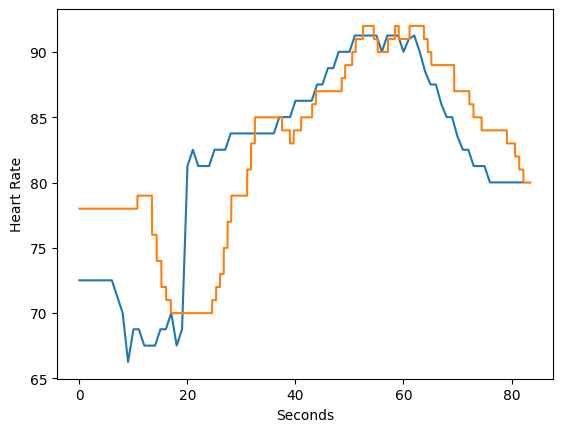

In [15]:
# Taking frequency with the highest power as the pulse signal

values = []

window = 6

lower_bound = window
upper_bound = int(final_signal.shape[0] / fps) - window

for i in range(lower_bound, upper_bound, 1):
    x = (final_signal[int((i - window) * fps):int((i + window) * fps)])
    (f_r, S_r) = periodogram(x, fps, nfft=len(x) * 4, scaling='density')

    f = f_r[S_r.argmax()]

    hr = 60 *f
    if i == window:
        values.extend([hr] * window)

    values.append(hr)


values.extend([values[-1]] * window)

import matplotlib.pyplot as plt

plt.plot(values)
plt.plot(gt_time, gt_hr)
plt.xlabel('Seconds')
plt.ylabel('Heart Rate')
plt.show()

In [16]:
# Mean heart rate in the GT signal
print(np.mean(values))
print(np.mean(gt_hr))

81.74936145595527
82.57338212634822
